In [325]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from collections import defaultdict
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math



## NOTES:
- comparing trial 1 vs trial 2 for each odor, which are 37 time steps apart, show that, on average, signal intensity decays
- the decay in signal intensity seems to be constant through time; i.e. the decay between trial 1 and trial 2 for the 1st odor delivered seems to be the same as the last odor delivered
- the decay in signal intensity seems to largely apply to all odors regardless of their absolute intensity, i.e. peak traces with smaller amplitudes overall decay through time just as much as peak traces with larger amplitudes.

## Load DataFrame, exclude low intensity samples

In [326]:
df = pd.read_csv("/Volumes/mcbride/bjarnold/whole_AL_segmentation/results/peak_max_df.csv")
# samples_to_exclude = ['230913_ORL_GCaMP6f_F1', '230913_FCV_GCaMP6f_F1']
samples_to_exclude = ['230913_FCV_GCaMP6f_F1']
df = df[df.samp.isin(samples_to_exclude) == False].reset_index(drop=True)
print(f'Number of samples: {len(df.samp.unique())}')


Number of samples: 14


In [327]:
def reshape_X_Y(X,Y):
    X = np.array(X).reshape(-1,1)
    Y = np.array(Y).reshape(-1,1)
    return X,Y

def fit_linear_model_skl(X,Y):
    reg = linear_model.LinearRegression()
    Xr, Yr = reshape_X_Y(X,Y) # make each element a list, normally a list used if multiple features used
    reg.fit(Xr, Yr)
    return reg.coef_[0][0], reg.intercept_[0]

def fit_linear_model_huber_skl(X,Y):
    reg = linear_model.HuberRegressor()
    Xr, Yr = reshape_X_Y(X,Y) # make each element a list, normally a list used if multiple features used
    reg.fit(Xr, Yr.ravel()) # gave it .ravel() to avoid warning
    print(reg.coef_[0], reg.intercept_)
    return reg.coef_[0], reg.intercept_

linear_regression = fit_linear_model_huber_skl

## Plot slope of trial 1 vs. trial 2 per subpopulation
### Also look at variability of slopes among samples

0.778535424705714 0.0004541925301157724
subpop ORL coef: 0.778535424705714
subpop ORL intercept: 0.0004541925301157724
0.46197644382126873 0.00020388733478941346
subpop U52 coef: 0.46197644382126873
subpop U52 intercept: 0.00020388733478941346
0.46772789230657724 0.0003395824061906034
subpop FCV coef: 0.46772789230657724
subpop FCV intercept: 0.0003395824061906034
0.7079148143484023 0.00046281099674290086
0.7954118790829826 0.0008229061870378854
0.952291748780292 0.0008228807662836987
0.7336875172993836 0.0002346937415635931
0.6644004148564617 0.00014995454229006533
0.36395648207547054 0.00010992852253093315
0.5700253792137292 0.00048423283343348257
0.39476903030821014 0.00013064363991757992
0.33084971802954166 0.00023140991330228937
0.6807303688410037 0.00026242092773370217
0.5558561703461825 2.1848149265327073e-05
0.3750970618933496 0.0003550951170273617
0.4644519150177368 0.0006288661909955172
0.4493444993821244 0.00037365198892785163


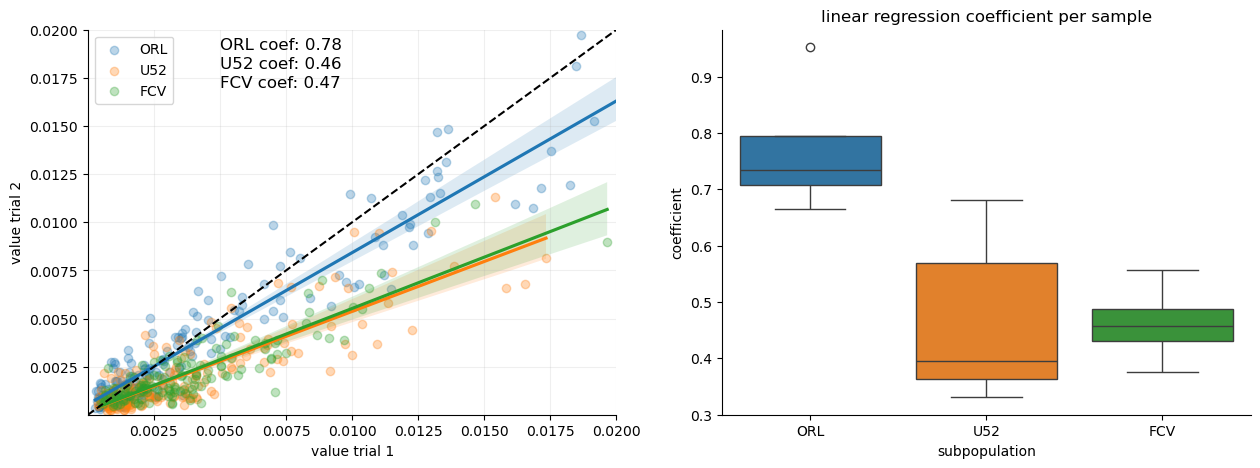

In [328]:

LM_subpop_slopes = defaultdict(float)
LM_samp_slopes = defaultdict(float)
reg_fits = defaultdict(list)

fig, axs = plt.subplots(1, 2, figsize=(15,5))
for i,subpop in enumerate(df.subpop.unique()):
    X = list(df[(df.trial==1) & (df.subpop == subpop)]['value'])
    Y = list(df[(df.trial==2) & (df.subpop == subpop)]['value'])
    sns.regplot(x=X,
                y=Y,
                label=subpop,
                scatter_kws={'alpha':0.3},
                ax=axs[0])

    # fit a linear model
    coef, intercept = linear_regression(X,Y)
    LM_subpop_slopes[subpop] = coef
    
    # reg = linear_model.LinearRegression()
    # Xr = np.array(X).reshape(-1,1) # make each element a list, normally a list used if multiple features used
    # Yr = np.array(Y).reshape(-1,1)
    # reg.fit(Xr, Yr)
    print(f'subpop {subpop} coef:', coef)
    print(f'subpop {subpop} intercept:', intercept)
    # print the re.coef_ value to axs[0]
    axs[0].text(0.005, 0.019-i*0.001, f'{subpop} coef: {coef:.2f}', fontsize=12)
    # axs[0].text(0.3, 0.95-i*0.05, f"{subpop} coeff: {reg.coef_[0][0]:.2f}", transform=plt.gca().transAxes)
    # calculate p-value, which scikit learn does not calculate
    # model = sm.OLS(Y, X)
    # results = model.fit()
    # print(f'p_value: {results.pvalues[0]}')

axs[0].set_xlabel('value trial 1')
axs[0].set_ylabel('value trial 2')
axs[0].set_xlim(0.00001,0.02)
axs[0].set_ylim(0.00001,0.02)
# create legend to label the regression lines that has the same colors as the subpopulations
axs[0].legend(loc='upper left')
# plot the correlation between the two trials and print this in the upper left corner
# add x=y line to axs[0]
axs[0].plot([0,1],[0,1], color='black', linestyle='--')
# add grid lines 
axs[0].grid(True, alpha=0.2)




for i,samp in enumerate(df.samp.unique()):
    subpop = df[df.samp == samp].subpop.unique()[0]
    X = list(df[(df.trial==1) & (df.samp == samp)]['value'])
    Y = list(df[(df.trial==2) & (df.samp == samp)]['value'])

    # fit a linear model
    coef, intercept = linear_regression(X,Y)
    LM_samp_slopes[samp] = coef
    # reg = linear_model.LinearRegression()
    # Xr = np.array(X).reshape(-1,1) # make each element a list, normally a list used if multiple features used
    # Yr = np.array(Y).reshape(-1,1)
    # reg.fit(Xr, Yr)
    reg_fits['subpop'].append(subpop)
    reg_fits['coef'].append(coef)

reg_fits_df = pd.DataFrame(reg_fits)
sns.boxplot(data=reg_fits_df, x='subpop', y='coef', ax=axs[1], hue='subpop')
axs[1].set_ylabel('coefficient')
axs[1].set_xlabel('subpopulation')
axs[1].set_title('linear regression coefficient per sample')
sns.despine()

## Visualize slopes per sample

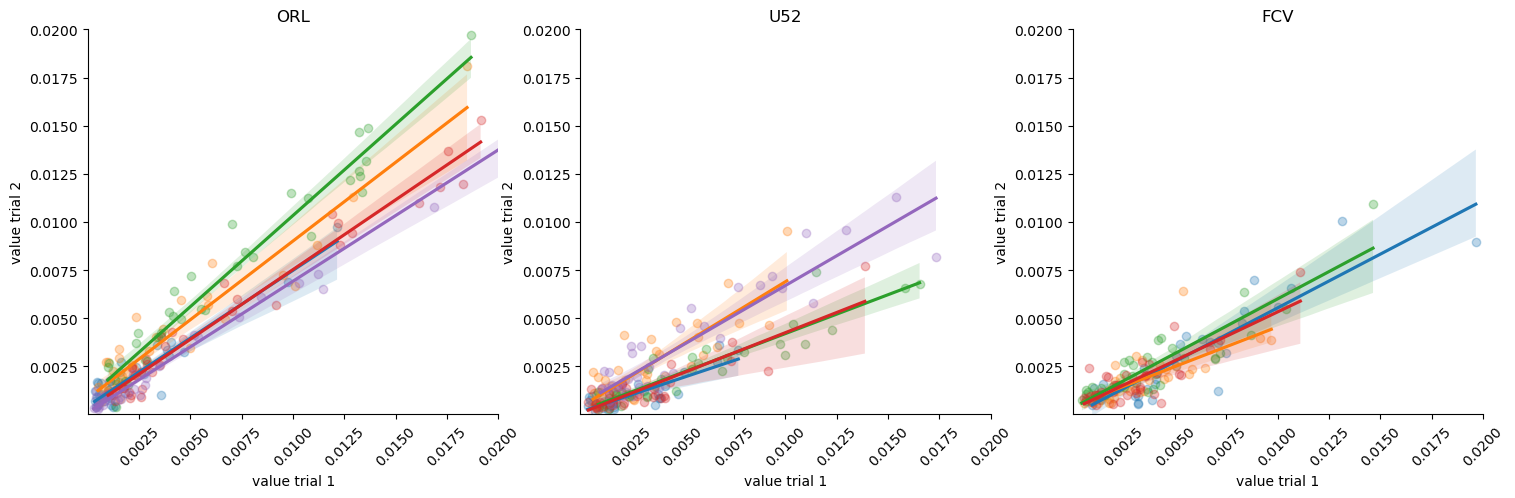

In [329]:

fig, axs = plt.subplots(1, 3, figsize=(18,5))
for i,subpop in enumerate(df.subpop.unique()):
    for samp in df[df.subpop == subpop].samp.unique():

        X = list(df[(df.trial==1) & (df.samp == samp)]['value'])
        Y = list(df[(df.trial==2) & (df.samp == samp)]['value'])
        sns.regplot(x=X,
                    y=Y,
                    label=samp,
                    ax=axs[i],
                    scatter_kws={'alpha':0.3})
    axs[i].set_xlabel('value trial 1')
    axs[i].set_ylabel('value trial 2')
    axs[i].set_xlim(0.00001,0.02)
    axs[i].set_ylim(0.00001,0.02)
    axs[i].set_title(subpop)
    axs[i].tick_params(axis='x', rotation=45)
    
sns.despine()

## Since there's evidence of vairiability in slope among samples, let's fit a Linear Mixed Model (LMM)
### First convert data to wide format to do this

In [330]:
# convert df from long format to wide format by puting the values of each trial, 1 and 2, in separate columns
df_wide = df.pivot(index=['samp', 'subpop', 'odor', 'odor_order'], columns='trial', values='value')
df_wide.reset_index(inplace=True)
df_wide.columns = ['samp', 'subpop', 'odor', 'odor_order', 'trial1', 'trial2']
print(df_wide.head())
assert len(df_wide) == (df_wide.samp.nunique() * df_wide.odor.nunique())

                    samp subpop            odor  odor_order    trial1  \
0  230913_ORL_GCaMP6f_F1    ORL    1-octen-3-ol          35  0.000644   
1  230913_ORL_GCaMP6f_F1    ORL  2-ethylhexanol          32  0.003956   
2  230913_ORL_GCaMP6f_F1    ORL    benzaldehyde          30  0.004669   
3  230913_ORL_GCaMP6f_F1    ORL         camphor          34  0.009764   
4  230913_ORL_GCaMP6f_F1    ORL     decanal2.18          20  0.000961   

     trial2  
0  0.001049  
1  0.003057  
2  0.003238  
3  0.006896  
4  0.001286  


## Fit the LMM, plot distribution of slopes per subpopulation

`"signal_intensity ~ 1 + time"`: Here, `1` represents the fixed intercept, and `time` is the fixed effect of time on signal intensity.

`groups=data["group_id"]`: This argument groups the data by `group_id`, which is necessary for specifying different random effects within each group.

`re_formula="0 + time"`: This specifies that there are no random intercepts (`0`), and only the slopes for `time` are random within each group. The intercept is common across all groups.

/var/folders/m1/0x4jd4t51ws3hts4kt4yy68c0000gn/T/ipykernel_80635/2642486658.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  random_slope = mdf.random_effects[samp][0]


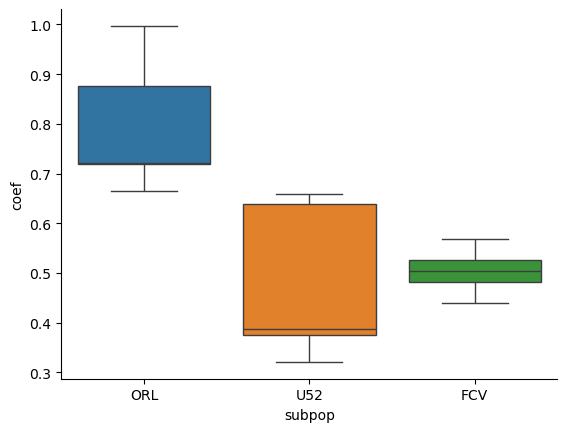

In [331]:
md = smf.mixedlm("trial2 ~ 1 + trial1", df_wide, groups=df_wide["samp"], re_formula="0 + trial1", )
mdf = md.fit()
# print(mdf.summary())
# print(mdf.random_effects)

fixed_slope = mdf.fe_params['trial1']
fixed_intercept = mdf.fe_params['Intercept']

LMM_results = defaultdict(list)
LMM_slopes = defaultdict(float)
for samp in mdf.random_effects:
    subpop = samp.split('_')[1]
    random_slope = mdf.random_effects[samp][0]
    slope = fixed_slope + random_slope
    LMM_results['subpop'].append(subpop)
    LMM_results['coef'].append(slope)
    LMM_results['samp'].append(samp)
    LMM_slopes[samp] = slope

LMM_results_df = pd.DataFrame(LMM_results)
sns.boxplot(data=LMM_results_df, x='subpop', y='coef', hue='subpop')
sns.despine()

fixed_intercept: 0.0003347623774814731


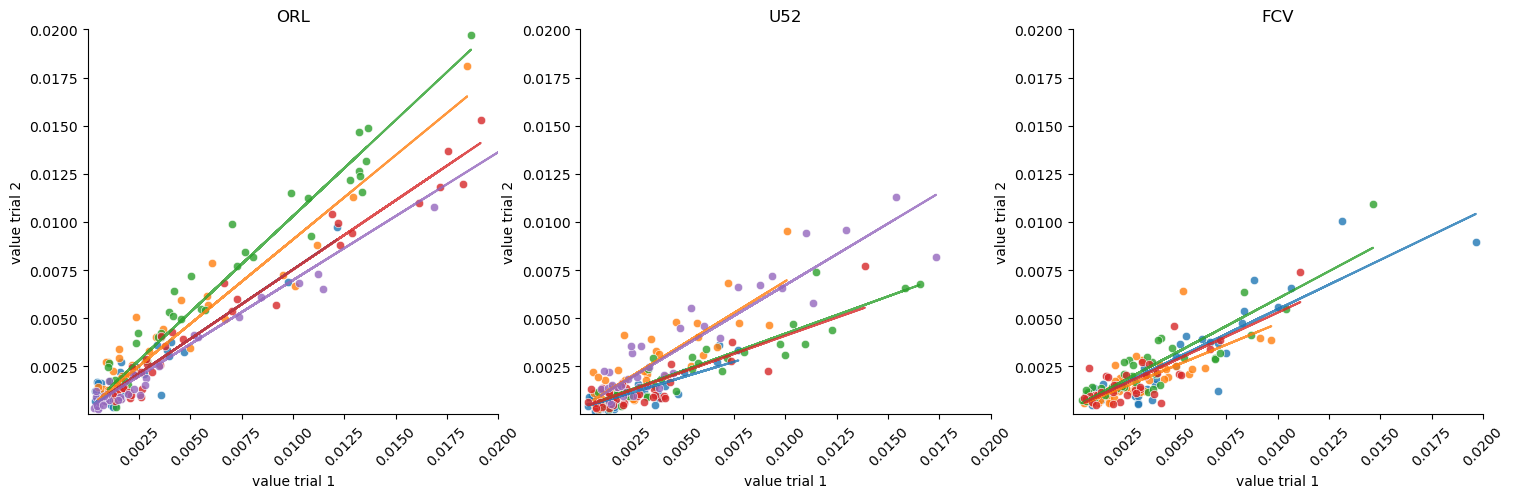

In [332]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))
for i,subpop in enumerate(LMM_results_df.subpop.unique()):
    for samp in LMM_results_df[LMM_results_df.subpop == subpop].samp.unique():

        slope = LMM_results_df[LMM_results_df.samp == samp]['coef']

        X = list(df[(df.samp == samp) & (df.trial == 1)]['value'])
        Y = list(df[(df.samp == samp) & (df.trial == 2)]['value'])
        axs[i].plot(X, [slope*x + fixed_intercept for x in X], alpha=0.8)
        sns.scatterplot(x=X, y=Y, alpha=0.8, ax=axs[i])


    axs[i].set_xlabel('value trial 1')
    axs[i].set_ylabel('value trial 2')
    axs[i].set_xlim(0.00001,0.02)
    axs[i].set_ylim(0.00001,0.02)
    axs[i].set_title(subpop)
    # rotate x-axis labels
    axs[i].tick_params(axis='x', rotation=45)
    
sns.despine()
print(f'fixed_intercept:', fixed_intercept)

Correction: 

$$S(t) = S_0*e^{-\lambda t}$$

Where
- $S_0$ is the starting signal (intrinsic brain activity), which we will assume is 1
- $S(t)$ is the decayed signal at time t
-  $\lambda$ is the decay rate
- $t$ is the time step

Since the slopes measured above are for $trial_2 = \beta * trial_1$, where $\beta$ measures the signal decay between trials are 36 time steps apart, then

$$ \beta = e^{-\lambda 36} $$
$$ ln(\beta) = -\lambda 36 $$
$$ \lambda = {-ln(\beta) \over 36} $$



In [333]:
print(sorted(df.odor_order.unique()))
# for each row in df, if trial == 2, add 37 to value of odor_order
df.loc[df.trial == 2, 'odor_order'] = df.loc[df.trial == 2, 'odor_order'] + 36
assert df.odor_order.nunique() == 72, f"number unique odors is {df.odor_order.nunique()}"
assert np.max(df.odor_order) == 71, f"max odor order is {np.max(df.odor_order)}"
print(sorted(df.odor_order.unique()))

def compute_correction_factor(slope, t):
    lamda = -1*np.log(slope)/36
    return np.exp(lamda*t)

values_corrected = []
for i,r in df.iterrows():

    slope = LMM_slopes[r.samp]
    # slope = LM_samp_slopes[r.samp]
    # slope = LM_subpop_slopes[r.subpop]
    time_point = r.odor_order
    correction_factor = compute_correction_factor(slope, time_point)
    # print(correction_factor)
    val_corrected = (r.value - fixed_intercept)*correction_factor
    # print(val_corrected)
    values_corrected.append(val_corrected)

df['value_corrected'] = values_corrected


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]


subpop ORL coef: [[1.00352134]]
subpop ORL intercept: [0.00044155]
subpop U52 coef: [[1.14450059]]
subpop U52 intercept: [-0.000425]
subpop FCV coef: [[1.10645341]]
subpop FCV intercept: [1.47544224e-05]


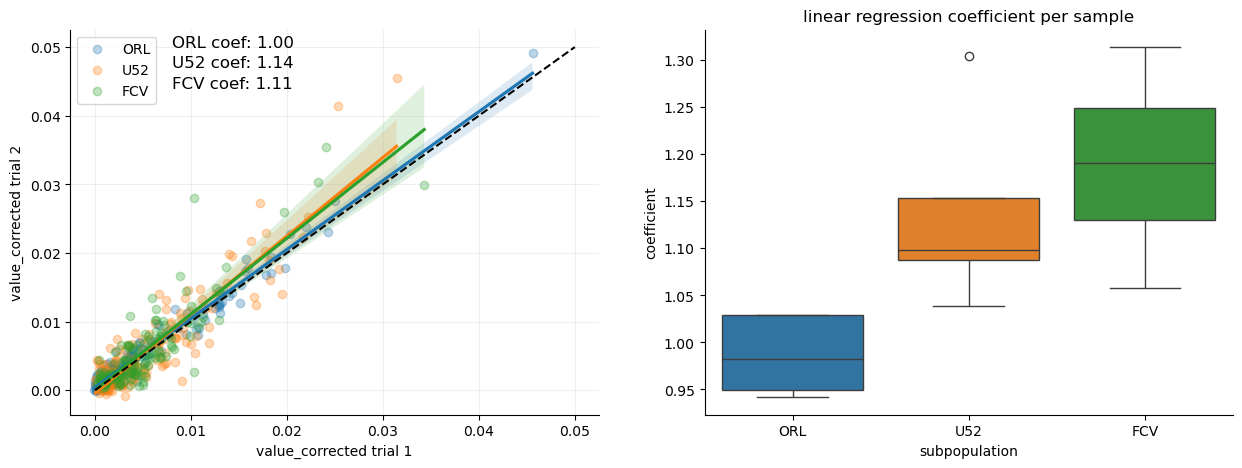

In [334]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for i,subpop in enumerate(df.subpop.unique()):
    X = list(df[(df.trial==1) & (df.subpop == subpop)]['value_corrected'])
    Y = list(df[(df.trial==2) & (df.subpop == subpop)]['value_corrected'])
    sns.regplot(x=X,
                y=Y,
                label=subpop,
                scatter_kws={'alpha':0.3},
                ax=axs[0])

    # fit a linear model
    reg = linear_model.LinearRegression()
    Xr = np.array(X).reshape(-1,1) # make each element a list, normally a list used if multiple features used
    Yr = np.array(Y).reshape(-1,1)
    reg.fit(Xr, Yr)
    print(f'subpop {subpop} coef:', reg.coef_)
    print(f'subpop {subpop} intercept:', reg.intercept_)
    # print the re.coef_ value to axs[0]
    axs[0].text(0.008, 0.05-i*0.003, f'{subpop} coef: {reg.coef_[0][0]:.2f}', fontsize=12)

axs[0].plot([0,0.05],[0,0.05], color='black', linestyle='--')
axs[0].set_xlabel('value_corrected trial 1')
axs[0].set_ylabel('value_corrected trial 2')
# axs[0].set_xlim(0.00001,0.02)
# axs[0].set_ylim(0.00001,0.02)
# create legend to label the regression lines that has the same colors as the subpopulations
axs[0].legend(loc='upper left')
# plot the correlation between the two trials and print this in the upper left corner
# add x=y line to axs[0]
# axs[0].plot([0,1],[0,1], color='black', linestyle='--')
# add grid lines 
axs[0].grid(True, alpha=0.2)


reg_fits = defaultdict(list)
for i,samp in enumerate(df.samp.unique()):
    subpop = df[df.samp == samp].subpop.unique()[0]
    X = list(df[(df.trial==1) & (df.samp == samp)]['value_corrected'])
    Y = list(df[(df.trial==2) & (df.samp == samp)]['value_corrected'])

    # fit a linear model
    reg = linear_model.LinearRegression()
    Xr = np.array(X).reshape(-1,1) # make each element a list, normally a list used if multiple features used
    Yr = np.array(Y).reshape(-1,1)
    reg.fit(Xr, Yr)
    reg_fits['subpop'].append(subpop)
    reg_fits['coef'].append(reg.coef_[0][0])

reg_fits_df = pd.DataFrame(reg_fits)
sns.boxplot(data=reg_fits_df, x='subpop', y='coef', hue='subpop', ax=axs[1])
axs[1].set_ylabel('coefficient')
axs[1].set_xlabel('subpopulation')
axs[1].set_title('linear regression coefficient per sample')
sns.despine()

In [335]:
df

,samp,subpop,trial,odor,value,odor_order,value_corrected
0,230913_ORL_GCaMP6f_F1,ORL,1,hexanal4.375,0.000476,0,0.000141
1,230913_ORL_GCaMP6f_F1,ORL,2,hexanal4.375,0.000475,36,0.000195
2,230913_ORL_GCaMP6f_F2,ORL,1,hexanal4.375,0.001602,0,0.001268
3,230913_ORL_GCaMP6f_F2,ORL,2,hexanal4.375,0.001477,36,0.001304
4,230914_ORL_GCaMP6f_F1,ORL,1,hexanal4.375,0.001039,0,0.000704
...,...,...,...,...,...,...,...
1003,230914_FCV_GCaMP6f_F2,FCV,2,1-octen-3-ol,0.000843,71,0.002574
1004,230914_FCV_GCaMP6f_F3,FCV,1,1-octen-3-ol,0.002496,35,0.003741
1005,230914_FCV_GCaMP6f_F3,FCV,2,1-octen-3-ol,0.002087,71,0.005335
1006,230915_FCV_GCaMP6f_F1,FCV,1,1-octen-3-ol,0.001734,35,0.002766


[0.46301306831122807,
 0.46301306831122807,
 0.46301306831122807,
 0.463013068311228,
 0.4630130683112281,
 0.46301306831122807,
 0.46301306831122785,
 0.4630130683112283,
 0.46301306831122824,
 0.4630130683112278,
 0.46301306831122785,
 0.4630130683112283,
 0.46301306831122824,
 0.46301306831122746,
 0.4630130683112283,
 0.4630130683112283,
 0.46301306831122824,
 0.46301306831122835,
 0.4630130683112274,
 0.46301306831122824,
 0.4630130683112274,
 0.4630130683112283,
 0.4630130683112283,
 0.46301306831122824,
 0.4630130683112283,
 0.46301306831122824,
 0.4630130683112283,
 0.46301306831122657,
 0.4630130683112283,
 0.4630130683112283,
 0.46301306831122824,
 0.4630130683112283,
 0.4630130683112283,
 0.4630130683112283,
 0.4630130683112283,
 0.4630130683112283,
 0.4630130683112266,
 0.4630130683112283,
 0.4630130683112283,
 0.46301306831122824,
 0.46301306831122835,
 0.4630130683112266,
 0.4630130683112299,
 0.46301306831122657,
 0.46301306831122996,
 0.4630130683112266,
 0.463013068311

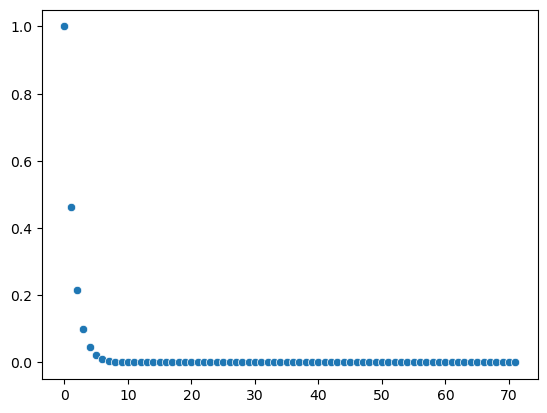

In [336]:
slope = 0.77
def exponential_decay(t, slope):
    return np.exp(-1*(slope)*t)


sns.scatterplot(x=range(72), y=[exponential_decay(t, slope) for t in range(72)])
y=[exponential_decay(t, slope) for t in range(72)]

# compute the ratio of the n+1th value to the nth value
ratios = []
for i in range(1, len(y)):
    ratios.append(y[i]/y[i-1])
ratios

In [337]:
# md = smf.mixedlm("trial2 ~ trial1", df_wide,  groups=df_wide["subpop"], re_formula="0 + trial1", vc_formula={"samp": "0 + C(samp)"})
# mdf = md.fit()
# # print(mdf.summary())

# fixed_slope = mdf.fe_params['trial1']
# fixed_intercept = mdf.fe_params['Intercept']

# reg_fits = defaultdict(list)
# for subpop in mdf.random_effects:
#     random_group_slope = mdf.random_effects[subpop][0]
#     print("random_group_slope", random_group_slope)
#     for i in mdf.random_effects[subpop][1:]:
#         random_samp_slope = fixed_slope + random_group_slope + i
#         reg_fits['subpop'].append(subpop)
#         reg_fits['coef'].append(random_samp_slope)


# reg_fits_df = pd.DataFrame(reg_fits)
# sns.boxplot(data=reg_fits_df, x='subpop', y='coef')

In [338]:
# go through dataframe, calculate difference between trial 1 and trial 2 for each odor, keeping track of odor order and subpop
ratios = defaultdict(list)
for samp in df.samp.unique():
    tmp = df[df.samp==samp].reset_index(drop=True)
    
    tmp1 = tmp[tmp.trial==1].sort_values('odor_order').reset_index(drop=True)
    tmp2 = tmp[tmp.trial==2].sort_values('odor_order').reset_index(drop=True)
    ratio = list(tmp2.value/tmp1.value)
    subpop = tmp.subpop.unique()[0]

    ratios['ratio'].extend(ratio)
    ratios['subpop'].extend([subpop]*len(ratio))
    ratios['samp'].extend([samp]*len(ratio))
    ratios['odor'].extend(tmp1.odor)
    ratios['odor_order'].extend(tmp1.odor_order)
    ratios['avg'].extend((tmp1.value + tmp2.value)/2)


ratios_df = pd.DataFrame(ratios)
ratios_df

,ratio,subpop,samp,odor,odor_order,avg
0,0.999495,ORL,230913_ORL_GCaMP6f_F1,hexanal4.375,0,0.000475
1,0.424496,ORL,230913_ORL_GCaMP6f_F1,hexanal4.03,1,0.000800
2,0.878991,ORL,230913_ORL_GCaMP6f_F1,hexanal2.825,2,0.001008
3,1.993566,ORL,230913_ORL_GCaMP6f_F1,heptanal4.51,3,0.000789
4,1.069798,ORL,230913_ORL_GCaMP6f_F1,heptanal4.065,4,0.000885
...,...,...,...,...,...,...
499,0.665046,FCV,230915_FCV_GCaMP6f_F1,oxoisophorone,31,0.009241
500,0.698766,FCV,230915_FCV_GCaMP6f_F1,2-ethylhexanol,32,0.003172
501,0.777014,FCV,230915_FCV_GCaMP6f_F1,hexanoic acid,33,0.002329
502,0.931473,FCV,230915_FCV_GCaMP6f_F1,camphor,34,0.004761


subpop ORL coef: [[-0.00764344]]
subpop ORL intercept: [1.2355465]

subpop U52 coef: [[0.00183382]]
subpop U52 intercept: [0.6283736]

subpop FCV coef: [[0.00483881]]
subpop FCV intercept: [0.59165599]



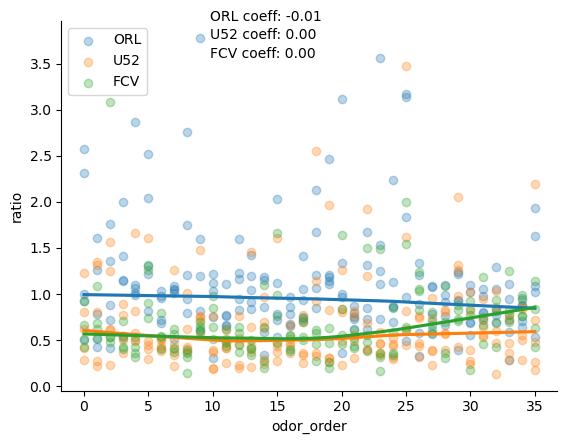

In [339]:
    
for i,subpop in enumerate(ratios_df.subpop.unique()):
    X = ratios_df[(ratios_df.subpop == subpop)]['odor_order']
    Y = ratios_df[(ratios_df.subpop == subpop)]['ratio']
    sns.regplot(x=X,
                y=Y,
                label=subpop,
                lowess=True,
                scatter_kws={'alpha':0.3})
    reg = linear_model.LinearRegression()
    Xr = np.array(X).reshape(-1,1) # make each element a list, normally a list used if multiple features used
    Yr = np.array(Y).reshape(-1,1)
    reg.fit(Xr, Yr)
    print(f'subpop {subpop} coef:', reg.coef_)
    print(f'subpop {subpop} intercept:', reg.intercept_)
    plt.text(0.3, 1-i*0.05, f"{subpop} coeff: {reg.coef_[0][0]:.2f}", transform=plt.gca().transAxes)

    # model = sm.OLS(Y, X)
    # results = model.fit()
    # print(f"p value: {results.pvalues}")
    # print(f"coefficient: {results.params['odor_order']}")
    print()
plt.legend(loc='upper left')

sns.despine()

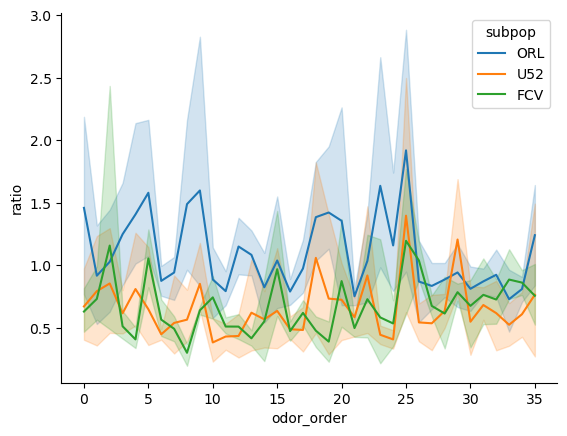

In [340]:
sns.lineplot(x='odor_order', y='ratio', hue='subpop', data=ratios_df)
sns.despine()

subpop ORL coef: [[-28.71687172]]
subpop ORL intercept: [1.22592564]
subpop U52 coef: [[-15.2151593]]
subpop U52 intercept: [0.70577113]
subpop FCV coef: [[-29.33752571]]
subpop FCV intercept: [0.76531462]


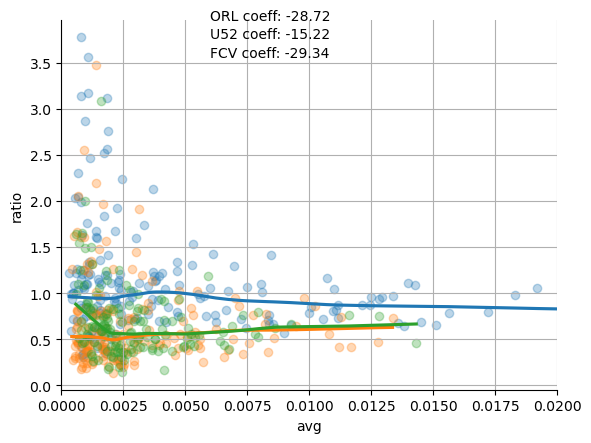

In [341]:
tmp_df = ratios_df[ratios_df.avg >= 0.00]
# tmp_df = ratios_df[(ratios_df.avg >= 0.00) & (ratios_df.subpop == "ORL")]
for i,subpop in enumerate(ratios_df.subpop.unique()):
    X = tmp_df[(tmp_df.subpop == subpop)]['avg']
    Y = tmp_df[(tmp_df.subpop == subpop)]['ratio']
    sns.regplot(x=X,
                y=Y,
                lowess=True,
                label=subpop,
                scatter_kws={'alpha':0.3})
    reg = linear_model.LinearRegression()
    Xr = np.array(X).reshape(-1,1) # make each element a list, normally a list used if multiple features used
    Yr = np.array(Y).reshape(-1,1)
    reg.fit(Xr, Yr)
    print(f'subpop {subpop} coef:', reg.coef_)
    print(f'subpop {subpop} intercept:', reg.intercept_)
    plt.text(0.3, 1-i*0.05, f"{subpop} coeff: {reg.coef_[0][0]:.2f}", transform=plt.gca().transAxes)
plt.xlim(0, 0.02)
# plt.xscale('log')
# plt.yscale('log')
sns.despine()
plt.grid()


[[0.00483881]]
[0.59165599]


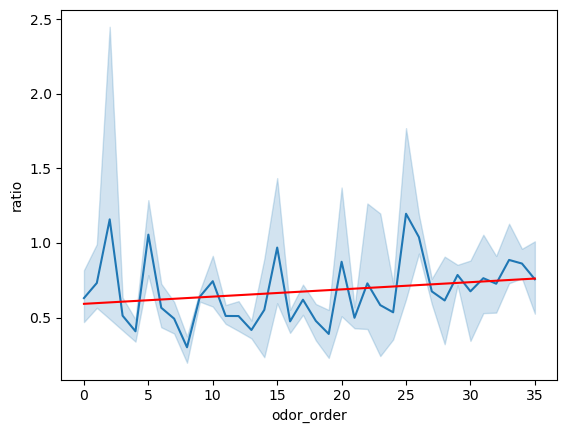

In [342]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
subpop='FCV'
X = list(ratios_df[ratios_df.subpop==subpop].odor_order)
y = list(ratios_df[ratios_df.subpop==subpop].ratio)
X = np.array(X).reshape(-1,1) # make each element a list, normally a list used if multiple features used
y = np.array(y).reshape(-1,1)
reg.fit(X, y)
print(reg.coef_)
print(reg.intercept_)
sns.lineplot(x='odor_order', y='ratio', data=ratios_df[ratios_df.subpop==subpop])
plt.plot(X, reg.predict(X), color='red')


In [343]:
# fit a linear model to data ratios_df[ratios_df.subpop=='FCV']
import statsmodels.api as sm
X = sm.add_constant(ratios_df[ratios_df.subpop=='FCV'].odor_order)
y = ratios_df[ratios_df.subpop=='FCV'].ratio
model = sm.OLS(y, X)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.576
Date:                Sun, 05 May 2024   Prob (F-statistic):              0.111
Time:                        22:31:01   Log-Likelihood:                -62.390
No. Observations:                 144   AIC:                             128.8
Df Residuals:                     142   BIC:                             134.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5917      0.061      9.644      0.000       0.470       0.713
odor_order     0.0048      0.003      1.605      0.111      -0.001       0.011
==============================================================================
Omnibus:                      114.366   Durbin-Watson:                   1.512
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1238.113
Skew:                           2.761   Prob(JB):                    1.40e-269
Kurtosis:                      16.261   Cond. No.                         39.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [344]:
sns.histplot(df, x='paraffin_subtracted_vals', alpha=0.5)
sns.histplot(df, x='peak_value', alpha=0.5)
plt.axvline(0, color='black', linestyle='--')
sns.despine()

ValueError: Could not interpret value `paraffin_subtracted_vals` for `x`. An entry with this name does not appear in `data`.